In [1]:
import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler, FunctionTransformer
from sklearn.metrics import confusion_matrix

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import random
import numpy as np
import scipy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn_image as isns

sns.set_style("darkgrid")
isns.set_image(origin="upper")

from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor

from utils import CustomImageDataset
from tqdm.notebook import tqdm

import os


from models import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(f"Using {device} device")

Using cuda device


In [2]:
train_dataset = CustomImageDataset("./data/train_data.csv", normalize=True, batch_size=2000, device=device)
test_dataset = CustomImageDataset("./data/test_data.csv", normalize=True, batch_size=2000, device=device)

In [3]:
train_dataset[0][0].device

device(type='cuda', index=0)

## Dense Autoencoder

In [4]:
code_size = 64

encoder = EncoderDense(train_dataset[0][0].shape[1:], code_size, device=device)
decoder = DecoderDense(code_size, train_dataset[0][0].shape[1:], device=device)
autoencoder = AE(encoder, decoder)
autoencoder

AE(
  (encoder): EncoderDense(
    (layer1): Linear(in_features=784, out_features=400, bias=True)
    (layer2): Linear(in_features=400, out_features=200, bias=True)
    (layer3): Linear(in_features=200, out_features=100, bias=True)
    (layer4): Linear(in_features=100, out_features=64, bias=True)
    (relu): ReLU()
    (sigmoid): Sigmoid()
  )
  (decoder): DecoderDense(
    (layer1): Linear(in_features=64, out_features=100, bias=True)
    (layer2): Linear(in_features=100, out_features=200, bias=True)
    (layer3): Linear(in_features=200, out_features=400, bias=True)
    (layer4): Linear(in_features=400, out_features=784, bias=True)
    (relu): ReLU()
    (sigmoid): Sigmoid()
  )
)

In [5]:
learning_rate = 1e-3
epochs = 500

# loss_fn = nn.BCELoss()
loss_fn = nn.MSELoss()
print(loss_fn)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate)

MSELoss()


In [6]:
for i in range(epochs):
    
    print(f"Epoch {i+1:3d}/{epochs}: ", end="")

    # Train
    autoencoder.train()
    train_loss = 0
    for batch, (X, y) in enumerate(train_dataset):
        pred = autoencoder(X)

        loss = loss_fn(pred, X)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    

    # Test
    autoencoder.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in test_dataset:
            pred = autoencoder(X)

            test_loss += loss_fn(pred, X).item()

    print(f"Train loss: {train_loss/len(train_dataset):>7f}, Test loss: {test_loss/len(test_dataset):>7f}")


Epoch   1/500: Train loss: 0.208894, Test loss: 0.185121
Epoch   2/500: Train loss: 0.144787, Test loss: 0.097316
Epoch   3/500: Train loss: 0.100131, Test loss: 0.096613
Epoch   4/500: Train loss: 0.093747, Test loss: 0.088812
Epoch   5/500: Train loss: 0.090189, Test loss: 0.087630
Epoch   6/500: Train loss: 0.087790, Test loss: 0.085652
Epoch   7/500: Train loss: 0.086957, Test loss: 0.085716
Epoch   8/500: Train loss: 0.086803, Test loss: 0.085305
Epoch   9/500: Train loss: 0.086606, Test loss: 0.085224
Epoch  10/500: Train loss: 0.086477, Test loss: 0.085099
Epoch  11/500: Train loss: 0.086406, Test loss: 0.085042
Epoch  12/500: Train loss: 0.086358, Test loss: 0.085033
Epoch  13/500: Train loss: 0.086332, Test loss: 0.085015
Epoch  14/500: Train loss: 0.086312, Test loss: 0.084999
Epoch  15/500: Train loss: 0.086309, Test loss: 0.084984
Epoch  16/500: Train loss: 0.086308, Test loss: 0.084968
Epoch  17/500: Train loss: 0.086303, Test loss: 0.084958
Epoch  18/500: Train loss: 0.08

torch.Size([28, 28])


<Axes: >

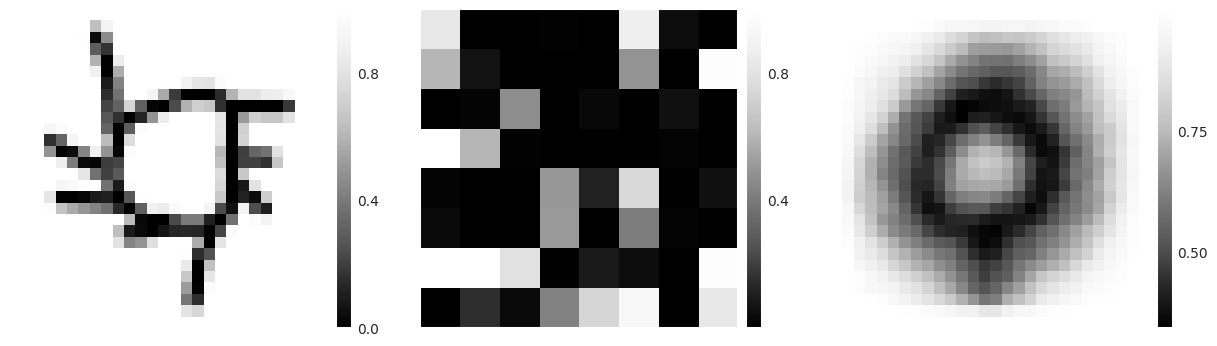

In [29]:
example_img = random.choice(train_dataset)
encoded_tensor = encoder(example_img[0])
decoded_tensor = decoder(encoded_tensor)


fig, ax = plt.subplots(1,3, figsize=(15,15))
print(random.choice(example_img[0]).shape)

rand_idx = random.choice(range(len(example_img[0])))

ex_img = example_img[0][rand_idx+1].to("cpu")
code = encoded_tensor[rand_idx].to("cpu").detach().numpy().reshape((8,8))
decoded = decoded_tensor[rand_idx].to("cpu").detach().numpy()
isns.imgplot(ex_img, cmap="Greys_r", ax=ax[0])
isns.imgplot(code, cmap="Greys_r", ax=ax[1])
isns.imgplot(decoded, cmap="Greys_r", ax=ax[2])


## VAE

In [3]:
code_size = 256

encoder = EncoderDenseVAE(train_dataset[0][0].shape[1:], code_size, std_scale=0.05, device=device)
decoder = DecoderDense(code_size, train_dataset[0][0].shape[1:], device=device)
autoencoder = VAE(encoder, decoder, beta=1e-6)
autoencoder

VAE(
  (encoder): EncoderDenseVAE(
    (layer1): Linear(in_features=784, out_features=400, bias=True)
    (layer2): Linear(in_features=400, out_features=200, bias=True)
    (layer3): Linear(in_features=200, out_features=100, bias=True)
    (layer4): Linear(in_features=100, out_features=256, bias=True)
    (layer5): Linear(in_features=100, out_features=256, bias=True)
    (relu): ReLU()
    (sigmoid): Sigmoid()
  )
  (decoder): DecoderDenseVAE(
    (layer1): Linear(in_features=256, out_features=100, bias=True)
    (layer2): Linear(in_features=100, out_features=200, bias=True)
    (layer3): Linear(in_features=200, out_features=400, bias=True)
    (layer4): Linear(in_features=400, out_features=784, bias=True)
    (relu): ReLU()
    (sigmoid): Sigmoid()
  )
)

In [28]:
learning_rate = 1e-6
epochs = 100

# loss_fn = nn.CrossEntropyLoss()
# loss_fn = nn.BCELoss()
loss_fn = nn.MSELoss()
# loss_fn = nn.MSELoss()
print(loss_fn)

# optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate)
# optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate)
optimizer = torch.optim.RMSprop(autoencoder.parameters(), lr=learning_rate)

MSELoss()


In [29]:
train_loss_history = []
test_loss_history = []
for i in range(epochs):
    
    print(f"Epoch {i+1:3d}/{epochs}: ", end="")

    # Train
    autoencoder.train()
    train_loss = 0
    for batch, (X, y) in enumerate(train_dataset):
        z, _, _ = autoencoder(X)

        loss = loss_fn(X, z) + autoencoder.beta*autoencoder.encoder.kl_loss

        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()

    # Test
    autoencoder.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in test_dataset:
            z, _, _ = autoencoder(X)
            loss = loss_fn(X, z) + autoencoder.beta*autoencoder.encoder.kl_loss
            test_loss += loss.item()
    
    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)

    print(f"Train loss: {train_loss/len(train_dataset):>7f}, Test loss: {test_loss/len(test_dataset):>7f}")

Epoch   1/100: Train loss: 0.107613, Test loss: 0.106326
Epoch   2/100: Train loss: 0.107600, Test loss: 0.106322
Epoch   3/100: Train loss: 0.107596, Test loss: 0.106321
Epoch   4/100: Train loss: 0.107594, Test loss: 0.106319
Epoch   5/100: Train loss: 0.107592, Test loss: 0.106318
Epoch   6/100: Train loss: 0.107590, Test loss: 0.106317
Epoch   7/100: Train loss: 0.107589, Test loss: 0.106317
Epoch   8/100: Train loss: 0.107588, Test loss: 0.106316
Epoch   9/100: Train loss: 0.107587, Test loss: 0.106316
Epoch  10/100: Train loss: 0.107586, Test loss: 0.106315
Epoch  11/100: Train loss: 0.107585, Test loss: 0.106315
Epoch  12/100: Train loss: 0.107585, Test loss: 0.106314
Epoch  13/100: Train loss: 0.107584, Test loss: 0.106314
Epoch  14/100: Train loss: 0.107583, Test loss: 0.106314
Epoch  15/100: Train loss: 0.107582, Test loss: 0.106313
Epoch  16/100: Train loss: 0.107582, Test loss: 0.106313
Epoch  17/100: Train loss: 0.107581, Test loss: 0.106313
Epoch  18/100: Train loss: 0.10

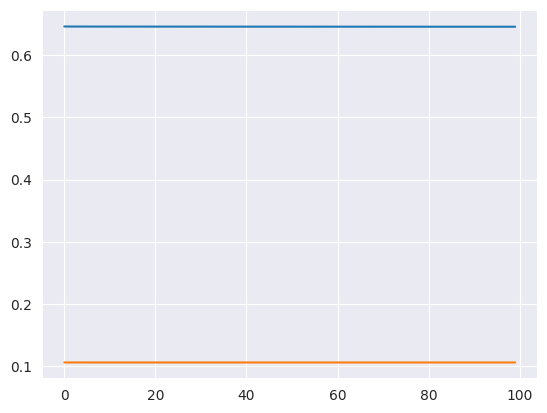

In [30]:
plt.plot(train_loss_history)
plt.plot(test_loss_history)
plt.show()

torch.Size([28, 28])


<Axes: >

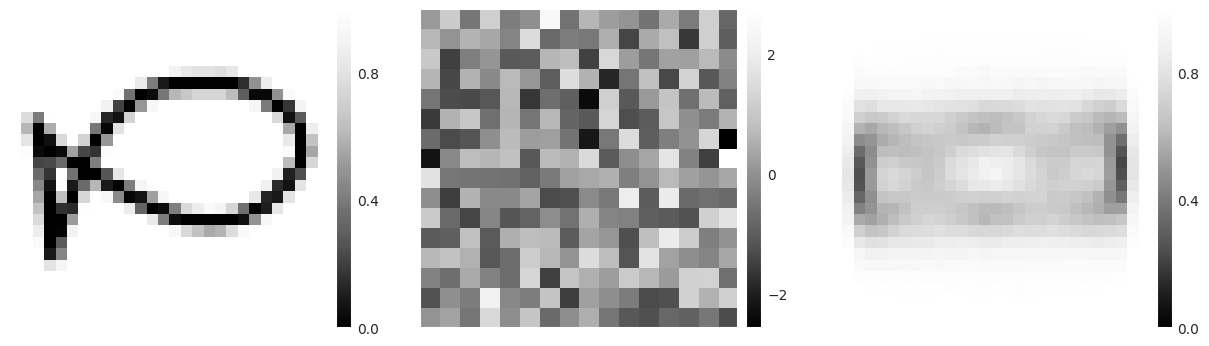

In [35]:
example_img = random.choice(train_dataset)
encoded_tensor, z_loc, z_log_scale = encoder(example_img[0])
decoded_tensor = decoder(encoded_tensor)


fig, ax = plt.subplots(1,3, figsize=(15,15))
print(random.choice(example_img[0]).shape)

rand_idx = random.choice(range(len(example_img[0])))

ex_img = example_img[0][rand_idx+1].to("cpu")
code = encoded_tensor[rand_idx].to("cpu").detach().numpy().reshape((16,16))
decoded = decoded_tensor[rand_idx].to("cpu").detach().numpy()
isns.imgplot(ex_img, cmap="Greys_r", ax=ax[0], vmin=0, vmax=1)
isns.imgplot(code, cmap="Greys_r", ax=ax[1], vmin=code.min())
isns.imgplot(decoded, cmap="Greys_r", ax=ax[2], vmin=0, vmax=1)